In [5]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import (
    RadiusNeighborsClassifier,
    NeighborhoodComponentsAnalysis,
    KNeighborsClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

data = {
    "model": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "train_score": [],
    "test_score": [],
}
models = pd.DataFrame(columns=data)

pd.options.display.max_columns = None
titanic = pd.read_csv(
    r"/kaggle/input/titanic/train.csv"
)
test = pd.read_csv(
    r"/kaggle/input/titanic/test.csv"
)
ids = test["PassengerId"]

test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


    pclass : Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

    sibsp	# of siblings / spouses aboard the Titanic

    parch	# of parents / children aboard the Titanic

    ticket	Ticket number

    fare	Passenger fare

    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


# EDA


In [6]:
titanic.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [7]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
titanic.isna().sum() * 100 / len(titanic)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

**We can see Age and Cabin colums have a lot of missing data. Gotta drop them**

# females have a much higher chance of survival than males

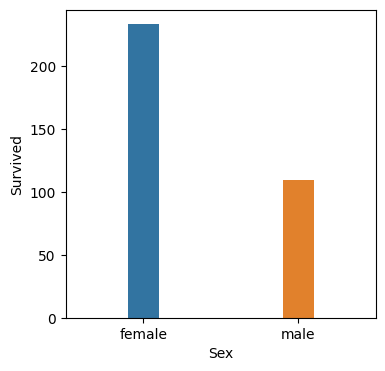

In [9]:
plt.figure(figsize=(4, 4))

data = titanic[titanic["Survived"] == 1]
sns.barplot(data=data, x="Sex", y="Survived", width=0.2, estimator="sum")
plt.show()

# No dependence on p-class is observed

39.76608187134503
25.43859649122807
34.7953216374269


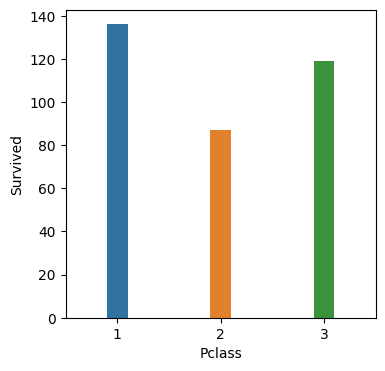

In [10]:
print(
    len(titanic[(titanic["Pclass"] == 1) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)
print(
    len(titanic[(titanic["Pclass"] == 2) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)

print(
    len(titanic[(titanic["Pclass"] == 3) & (titanic["Survived"] == 1)])
    * 100
    / len(titanic[titanic["Survived"] == 1])
)


plt.figure(figsize=(4, 4))
data = titanic[titanic["Survived"] == 1]
sns.barplot(data=data, x="Pclass", y="Survived", width=0.2, estimator="sum")
plt.show()

0  : 61.40350877192982
1  : 32.748538011695906
2  : 3.801169590643275
3  : 1.1695906432748537
4  : 0.8771929824561403


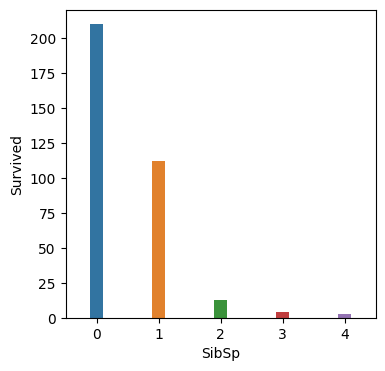

In [12]:
data = titanic[titanic["Survived"] == 1]

arr = data["SibSp"].unique()
arr = list(arr)
arr.sort()
for val in arr:
    print(val, " :", len(data[(data["SibSp"] == val)]) * 100 / len(data))

plt.figure(figsize=(4, 4))
sns.barplot(data=data, x="SibSp", y="Survived", width=0.2, estimator="sum")
plt.show()

# When you have less number of siblings or spouses, you will have a much higher chance of survival

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Survived'>

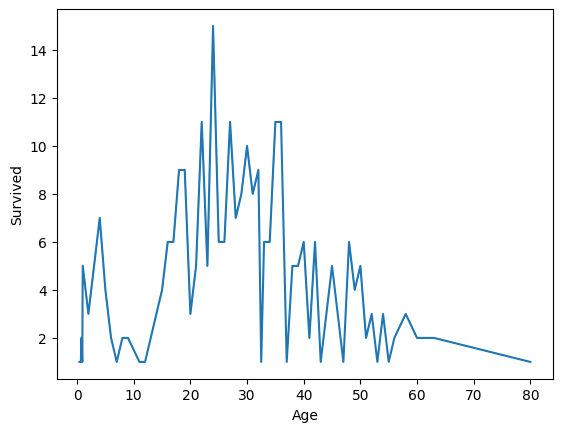

In [13]:
data = titanic[titanic["Survived"] == 1]
sns.lineplot(data=data, x="Age", y="Survived", estimator="sum")

# Cleaning


In [14]:
Drop_columns = ["Pclass", "Cabin", "Name", "PassengerId", "Ticket"]
titanic = titanic.drop(columns=Drop_columns, axis="columns")
titanic["Embarked"] = titanic["Embarked"].fillna(titanic["Embarked"].mode()[0])
titanic["Age"] = titanic["Age"].fillna(int(titanic["Age"].mean()))

In [15]:
titanic.isna().sum()

Survived    0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# **New data frames discarded redundant columns**

In [16]:
titanic

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,1,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,0,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,0,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,0,female,29.0,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


### Encoding and Grouping


In [17]:
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = [
    "Unknown",
    "baby",
    "child",
    "teenager",
    "student",
    "young adult",
    "adult",
    "Senior",
]
titanic["AgeGroup"] = pd.cut(titanic["Age"], bins, labels=labels)
titanic = titanic.drop("Age", axis="columns")
titanic

,Survived,Sex,SibSp,Parch,Fare,Embarked,AgeGroup
0,0,male,1,0,7.2500,S,student
1,1,female,1,0,71.2833,C,adult
2,1,female,0,0,7.9250,S,young adult
3,1,female,1,0,53.1000,S,young adult
4,0,male,0,0,8.0500,S,young adult
...,...,...,...,...,...,...,...
886,0,male,0,0,13.0000,S,young adult
887,1,female,0,0,30.0000,S,student
888,0,female,1,2,23.4500,S,young adult
889,1,male,0,0,30.0000,C,young adult


In [18]:
titanic = pd.get_dummies(
    titanic, drop_first=True, columns=["Sex", "Embarked", "AgeGroup"]
)
for col in titanic.columns:
    if titanic[col].dtype == "bool":
        titanic[col] = titanic[col].astype("int32")
titanic

,Survived,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,AgeGroup_baby,AgeGroup_child,AgeGroup_teenager,AgeGroup_student,AgeGroup_young adult,AgeGroup_adult,AgeGroup_Senior
0,0,1,0,7.2500,1,0,1,0,0,0,1,0,0,0
1,1,1,0,71.2833,0,0,0,0,0,0,0,0,1,0
2,1,0,0,7.9250,0,0,1,0,0,0,0,1,0,0
3,1,1,0,53.1000,0,0,1,0,0,0,0,1,0,0
4,0,0,0,8.0500,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,13.0000,1,0,1,0,0,0,0,1,0,0
887,1,0,0,30.0000,0,0,1,0,0,0,1,0,0,0
888,0,1,2,23.4500,0,0,1,0,0,0,0,1,0,0
889,1,0,0,30.0000,1,0,0,0,0,0,0,1,0,0


## Same for testing data

In [19]:
Drop_columns = ["Pclass", "Cabin", "Name", "PassengerId", "Ticket"]
test = test.drop(columns=Drop_columns, axis="columns")

test["Embarked"] = test["Embarked"].fillna(test["Embarked"].mode()[0])
test["Age"] = test["Age"].fillna(int(test["Age"].mean()))
test["Fare"] = test["Fare"].fillna(test["Fare"].mean())
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = [
    "Unknown",
    "baby",
    "child",
    "teenager",
    "student",
    "young adult",
    "adult",
    "Senior",
]
test["AgeGroup"] = pd.cut(test["Age"], bins, labels=labels)


test = pd.get_dummies(test, drop_first=True, columns=["Sex", "Embarked", "AgeGroup"])
for col in test.columns:
    if test[col].dtype == "bool":
        test[col] = test[col].astype("int32")


test = test.drop(columns="Age", axis="columns")
test

,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,AgeGroup_baby,AgeGroup_child,AgeGroup_teenager,AgeGroup_student,AgeGroup_young adult,AgeGroup_adult,AgeGroup_Senior
0,0,0,7.8292,1,1,0,0,0,0,0,1,0,0
1,1,0,7.0000,0,0,1,0,0,0,0,0,1,0
2,0,0,9.6875,1,1,0,0,0,0,0,0,0,1
3,0,0,8.6625,1,0,1,0,0,0,0,1,0,0
4,1,1,12.2875,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,0,8.0500,1,0,1,0,0,0,0,1,0,0
414,0,0,108.9000,0,0,0,0,0,0,0,0,1,0
415,0,0,7.2500,1,0,1,0,0,0,0,0,1,0
416,0,0,8.0500,1,0,1,0,0,0,0,1,0,0


# Split data


In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    titanic.drop(columns="Survived", axis="columns"),
    titanic["Survived"],
    random_state=34,
    test_size=0.3,
)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(623, 13)
(623,)
(268, 13)
(268,)


# Models

- Logistic Regression
- k-Nearest Neighbors
- R-Nearest Neighbors
- Decision Tree Classifier
- Random Forest Classifier


## 1) LogisticRegression


In [21]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X=x_train, y=y_train)

train_score = log_reg.score(x_train, y_train)
test_score = log_reg.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.7913322632423756
train score =  0.8134328358208955


In [22]:
log_reg_prediction = log_reg.predict(x_test)
MAE = mean_absolute_error(y_pred=log_reg_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=log_reg_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.1865671641791045, 0.1865671641791045, 0.43193421279068006)

In [23]:
data = {
    "model": "LogisticRegression",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.186567,0.186567,0.431934,0.791332,0.813433


## 2) k-Nearest Neighbors


In [24]:
num_neighbors = int(np.sqrt(len(x_train)))

neighbors = [num_neighbors]
for i in range(9):
    neighbors.append(num_neighbors + i + 1)
for i in range(9):
    neighbors.append(num_neighbors - (i + 1))

KNC_models = []
Cross_valdation = []

for k in neighbors:
    KNC = KNeighborsClassifier(n_neighbors=k, algorithm="ball_tree")
    KNC.fit(X=x_train, y=y_train)
    valdation = cross_val_score(KNC, X=x_train, y=y_train, cv=4)
    KNC_models.append(KNC)
    Cross_valdation.append([k, np.mean(valdation), np.std(valdation)])

train_score = [KNC_.score(x_train, y_train) for KNC_ in KNC_models]
test_score = [KNC_.score(x_test, y_test) for KNC_ in KNC_models]


Cross_valdation_results = pd.DataFrame(
    Cross_valdation, columns=["K-neighbors", "mean_acc", "std"]
)

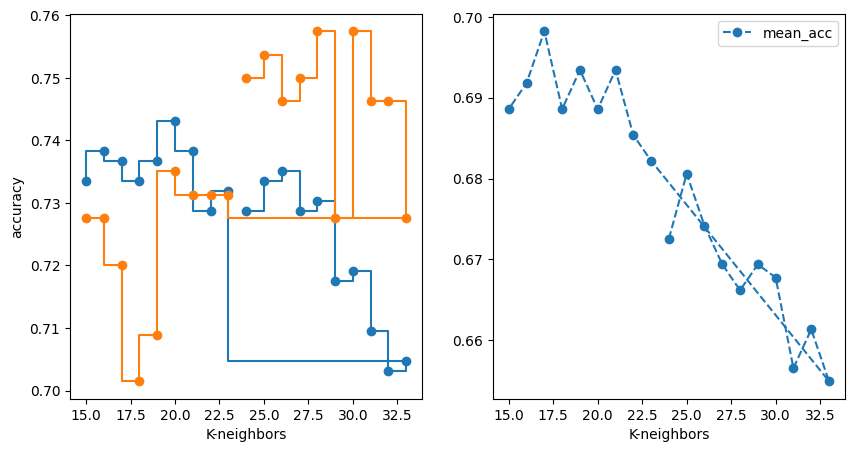

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("K-neighbors")
ax[0].set_ylabel("accuracy")
ax[0].plot(neighbors, train_score, marker="o", label="train", drawstyle="steps-post")
ax[0].plot(neighbors, test_score, marker="o", label="test", drawstyle="steps-post")

Cross_valdation_results.plot(
    x="K-neighbors", y="mean_acc", linestyle="--", marker="o", ax=ax[1]
)

plt.legend()
plt.show()

### In simpler terms, when the dataset changes, the model's performance fluctuates, suggesting that it is not consistently effective across different data scenarios.


In [26]:
KNC = KNeighborsClassifier(n_neighbors=28, algorithm="ball_tree")
KNC.fit(X=x_train, y=y_train)
train_score = KNC.score(x_train, y_train)
test_score = KNC.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.7303370786516854
train score =  0.7574626865671642


In [27]:
KNC_prediction = KNC.predict(x_test)
MAE = mean_absolute_error(y_pred=KNC_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=KNC_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.24253731343283583, 0.24253731343283583, 0.4924807746834752)

In [28]:
data = {
    "model": "KNeighborsClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.186567,0.186567,0.431934,0.791332,0.813433
1,KNeighborsClassifier,0.242537,0.242537,0.492481,0.730337,0.757463


## 3) R-Nearest Neighbors


In [29]:
R = 40

Raduisies = [R]
for i in range(20):
    Raduisies.append(R + i + 0.5)

for i in range(20):
    Raduisies.append(R - (i + 0.5))

RNC_models = []
Cross_valdation = []

for r in Raduisies:
    RNC = RadiusNeighborsClassifier(radius=r, algorithm="ball_tree")
    RNC.fit(X=x_train, y=y_train)
    valdation = cross_val_score(RNC, X=x_train, y=y_train, cv=4)
    RNC_models.append(RNC)
    Cross_valdation.append([r, np.mean(valdation), np.std(valdation)])

train_score = [RNC_.score(x_train, y_train) for RNC_ in RNC_models]
test_score = [RNC_.score(x_test, y_test) for RNC_ in RNC_models]


Cross_valdation_results = pd.DataFrame(
    Cross_valdation, columns=["R-neighbors", "mean_acc", "std"]
)

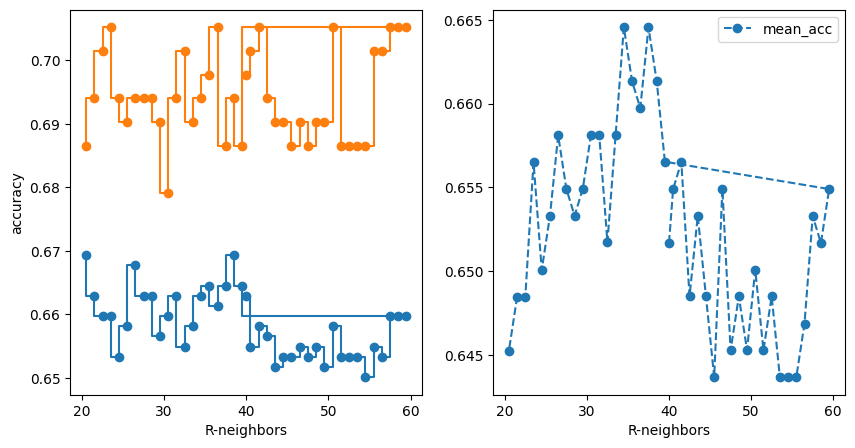

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("R-neighbors")
ax[0].set_ylabel("accuracy")
ax[0].plot(Raduisies, train_score, marker="o", label="train", drawstyle="steps-post")
ax[0].plot(Raduisies, test_score, marker="o", label="test", drawstyle="steps-post")

Cross_valdation_results.plot(
    x="R-neighbors", y="mean_acc", linestyle="--", marker="o", ax=ax[1]
)

plt.legend()
plt.show()

### Try 40.5 as a raduis


In [31]:
RNC = RadiusNeighborsClassifier(radius=40.5, algorithm="ball_tree")
RNC.fit(X=x_train, y=y_train)
train_score = RNC.score(x_train, y_train)
test_score = RNC.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.6548956661316212
train score =  0.7014925373134329


In [32]:
RNC_prediction = RNC.predict(x_test)
MAE = mean_absolute_error(y_pred=RNC_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=RNC_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.29850746268656714, 0.29850746268656714, 0.546358364708153)

In [33]:
data = {
    "model": "RadiusNeighborsClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.186567,0.186567,0.431934,0.791332,0.813433
1,KNeighborsClassifier,0.242537,0.242537,0.492481,0.730337,0.757463
2,RadiusNeighborsClassifier,0.298507,0.298507,0.546358,0.654896,0.701493


## 4) Decision Tree Classifier


In [34]:
DTC = DecisionTreeClassifier(random_state=42)
DTC.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

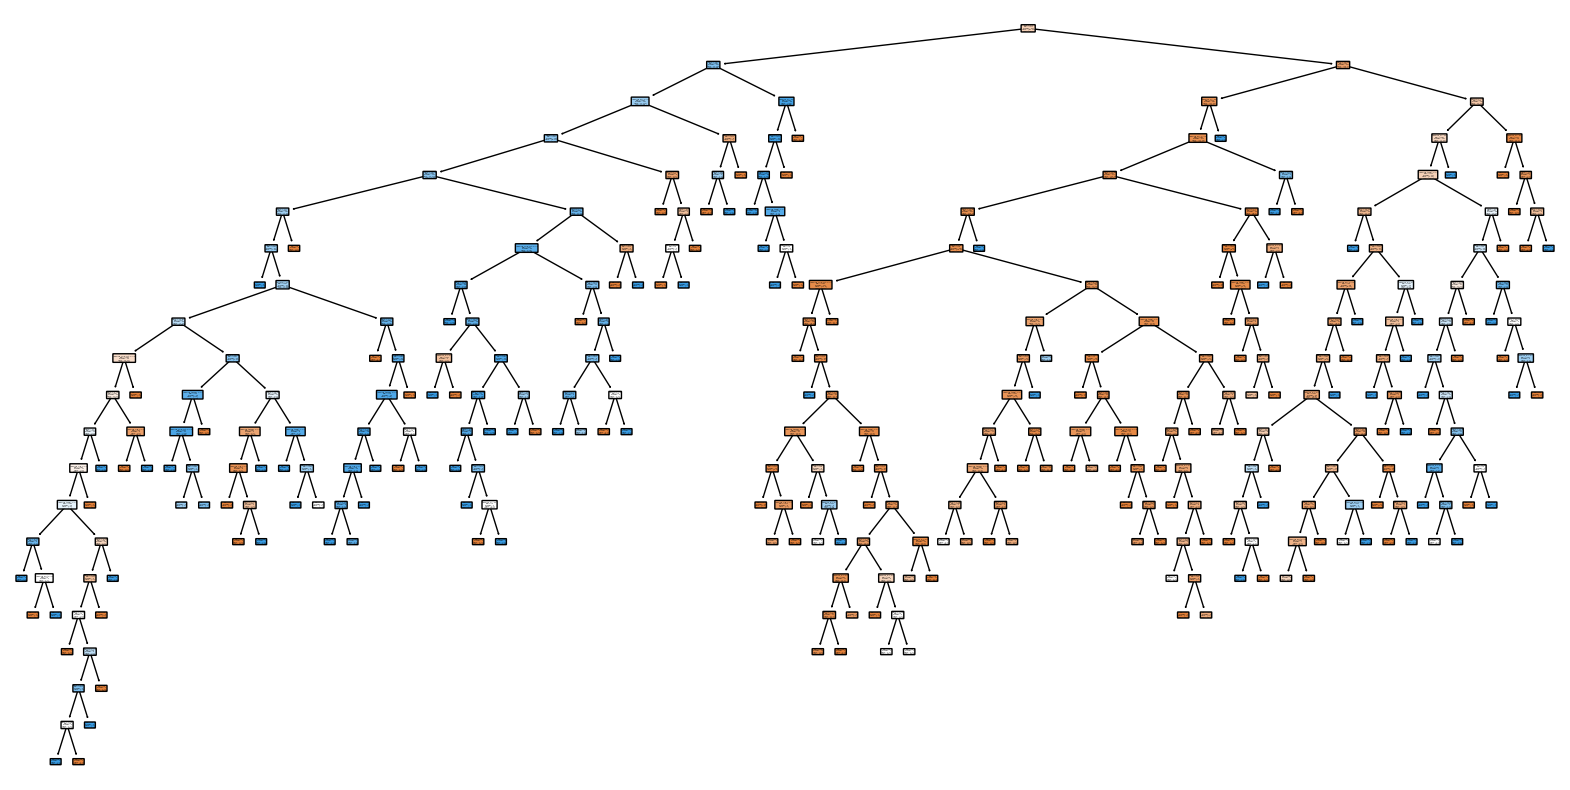

In [35]:
plt.figure(figsize=(20, 10))
plot_tree(
    DTC,
    class_names=["Yes HD", "No HD"],
    filled=True,
    rounded=True,
    feature_names=titanic.columns,
)
plt.show()

### I think this tree over fit the model


In [38]:
print(DTC.score(x_train, y_train))
print(DTC.score(x_test, y_test))

0.7945425361155698
0.7985074626865671


### as I expected, there is an overfit probelm, let's fix it by pruning the tree


In [39]:
path = DTC.cost_complexity_pruning_path(x_train, y_train)
alphas = path.ccp_alphas
alphas = alphas[:-1]
DTC_models = []

Cross_valdation = []

for alpha in alphas:
    DTC = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    DTC.fit(x_train, y_train)
    score = cross_val_score(DTC, x_train, y_train, cv=5)
    Cross_valdation.append([alpha, np.mean(score), np.std(score)])
    DTC_models.append(DTC)


train_score = [DTC_.score(x_train, y_train) for DTC_ in DTC_models]
test_score = [DTC_.score(x_test, y_test) for DTC_ in DTC_models]

alpha_results = pd.DataFrame(Cross_valdation, columns=["alpha", "mean_acc", "std"])

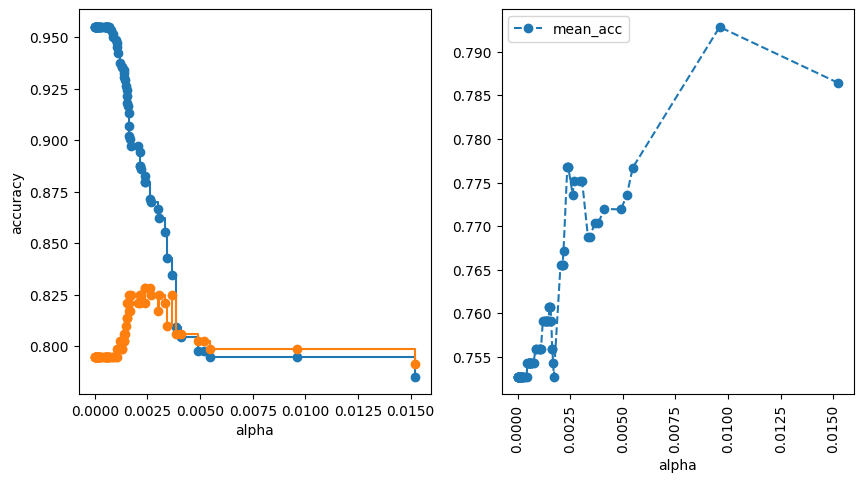

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")

ax[0].plot(alphas, train_score, marker="o", label="train", drawstyle="steps-post")
plt.xticks(rotation=90)

ax[0].plot(alphas, test_score, marker="o", label="test", drawstyle="steps-post")
plt.xticks(rotation=90)

alpha_results.plot(x="alpha", y="mean_acc", linestyle="--", marker="o", ax=ax[1])
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [41]:
alpha = alpha_results[
    (alpha_results["alpha"] <= 0.0025) & (alpha_results["alpha"] > 0.0024)
]["alpha"]

alpha

62    0.002408
63    0.002408
Name: alpha, dtype: float64

In [42]:
DTC_pruned = DecisionTreeClassifier(ccp_alpha=0.002408, random_state=42)
DTC_pruned.fit(x_train, y_train)
train_score = DTC_pruned.score(x_train, y_train)
test_score = DTC_pruned.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.8780096308186196
train score =  0.8283582089552238


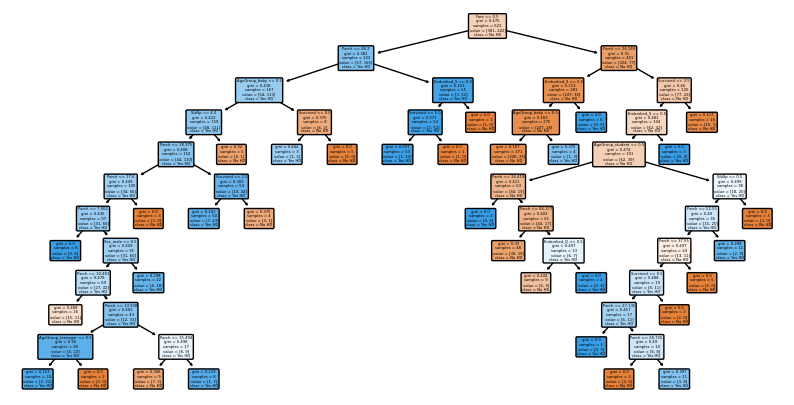

In [43]:
plt.figure(figsize=(10, 5))
plot_tree(
    DTC_pruned,
    class_names=["No HD", "Yes HD"],
    filled=True,
    rounded=True,
    feature_names=titanic.columns,
)
plt.show()

### Great work


In [47]:
DTC_pruned_prediction = DTC_pruned.predict(x_test)
MAE = mean_absolute_error(y_pred=DTC_pruned_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=DTC_pruned_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.17164179104477612, 0.17164179104477612, 0.41429674273976147)

In [46]:
data = {
    "model": "DecisionTreeClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.186567,0.186567,0.431934,0.791332,0.813433
1,KNeighborsClassifier,0.242537,0.242537,0.492481,0.730337,0.757463
2,RadiusNeighborsClassifier,0.298507,0.298507,0.546358,0.654896,0.701493
3,DecisionTreeClassifier,0.171642,0.171642,0.414297,0.878010,0.828358


### 5) Random Forest


In [48]:
RF = RandomForestClassifier(n_estimators=20, random_state=15, ccp_alpha=0.002408)
RF.fit(X=x_train, y=y_train)
RF.score(X=x_train, y=y_train), RF.score(X=x_test, y=y_test)

(0.884430176565008, 0.832089552238806)

In [49]:
path = DTC.cost_complexity_pruning_path(x_train, y_train)
alphas = path.ccp_alphas
alphas = alphas[:-1]

RF_models = []

Cross_valdation = []

for alpha in alphas:
    RF = RandomForestClassifier(n_estimators=20, random_state=0, ccp_alpha=alpha)
    RF.fit(x_train, y_train)
    score = cross_val_score(RF, x_train, y_train, cv=5)
    Cross_valdation.append([alpha, np.mean(score), np.std(score)])
    RF_models.append(RF)


train_score = [RF_.score(x_train, y_train) for RF_ in RF_models]
test_score = [RF_.score(x_test, y_test) for RF_ in RF_models]

alpha_results = pd.DataFrame(Cross_valdation, columns=["alpha", "mean_acc", "std"])

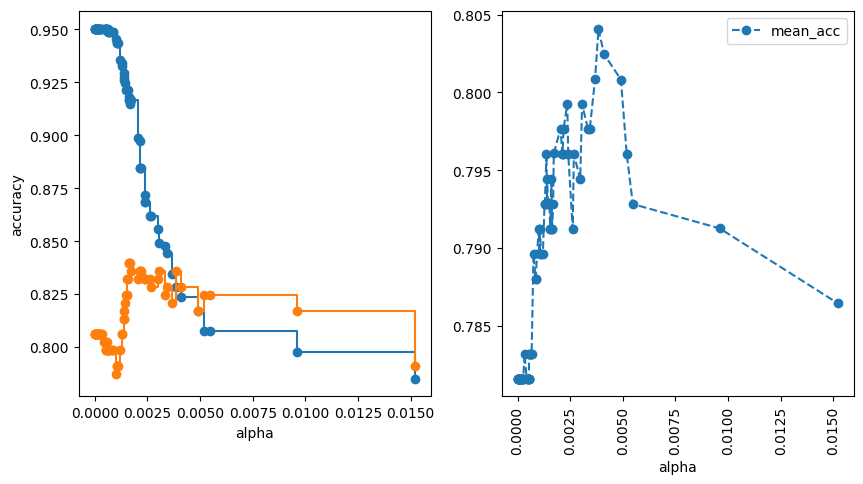

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")

ax[0].plot(alphas, train_score, marker="o", label="train", drawstyle="steps-post")
plt.xticks(rotation=90)

ax[0].plot(alphas, test_score, marker="o", label="test", drawstyle="steps-post")
plt.xticks(rotation=90)

alpha_results.plot(x="alpha", y="mean_acc", linestyle="--", marker="o", ax=ax[1])
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [51]:
alpha = alpha_results[
    (alpha_results["alpha"] <= 0.0025) & (alpha_results["alpha"] > 0.002)
]["alpha"]

alpha

56    0.002043
57    0.002126
58    0.002140
59    0.002140
60    0.002185
61    0.002364
62    0.002408
63    0.002408
Name: alpha, dtype: float64

In [52]:
RF = RandomForestClassifier(n_estimators=20, random_state=15, ccp_alpha=0.002364)
RF.fit(X=x_train, y=y_train)
train_score = RF.score(x_train, y_train)
test_score = RF.score(x_test, y_test)

print("train score = ", train_score)
print("train score = ", test_score)

train score =  0.8892455858747994
train score =  0.835820895522388


In [53]:
RF_prediction = RF.predict(x_test)
MAE = mean_absolute_error(y_pred=RF_prediction, y_true=y_test)
MSE = mean_squared_error(y_pred=RF_prediction, y_true=y_test)
RMSE = np.sqrt(MSE)
MAE, MSE, RMSE

(0.16417910447761194, 0.16417910447761194, 0.4051902077760665)

In [54]:
data = {
    "model": "RandomForestClassifier",
    "MAE": MAE,
    "MSE": MSE,
    "RMSE": RMSE,
    "train_score": train_score,
    "test_score": test_score,
}

models.loc[len(models)] = data
models

,model,MAE,MSE,RMSE,train_score,test_score
0,LogisticRegression,0.186567,0.186567,0.431934,0.791332,0.813433
1,KNeighborsClassifier,0.242537,0.242537,0.492481,0.730337,0.757463
2,RadiusNeighborsClassifier,0.298507,0.298507,0.546358,0.654896,0.701493
3,DecisionTreeClassifier,0.171642,0.171642,0.414297,0.878010,0.828358
4,RandomForestClassifier,0.164179,0.164179,0.405190,0.889246,0.835821


In [55]:
models.sort_values(by=["test_score"], ascending=[False])

,model,MAE,MSE,RMSE,train_score,test_score
4,RandomForestClassifier,0.164179,0.164179,0.405190,0.889246,0.835821
3,DecisionTreeClassifier,0.171642,0.171642,0.414297,0.878010,0.828358
0,LogisticRegression,0.186567,0.186567,0.431934,0.791332,0.813433
1,KNeighborsClassifier,0.242537,0.242537,0.492481,0.730337,0.757463
2,RadiusNeighborsClassifier,0.298507,0.298507,0.546358,0.654896,0.701493


In [57]:
predictions = log_reg.predict(test)

submmition = pd.DataFrame({"PassengerId": ids, "Survived": predictions})
submmition.to_csv( "submission.csv", index=False,)


**In summary, the Random Forest Classifier seems to perform the best among the models, with the lowest MAE, MSE, and RMSE, as well as high training and test scores. Decision Tree Classifier also shows good performance.**